Datasets carregados com sucesso.

Número de features utilizadas: 81
Tamanho do conjunto de teste (X_test): (115, 81)

--- Treinando e avaliando Linear Regression ---
  sis: MSE = 0.0000, RMSE = 0.0000, R2 = 1.0000
  ohs: MSE = 0.0000, RMSE = 0.0000, R2 = 1.0000
  oks: MSE = 0.0000, RMSE = 0.0000, R2 = 1.0000

--- Treinando e avaliando Random Forest Regressor ---
  sis: MSE = 0.0332, RMSE = 0.1823, R2 = 0.9971
  ohs: MSE = 0.0393, RMSE = 0.1981, R2 = 0.9995
  oks: MSE = 0.0087, RMSE = 0.0934, R2 = 0.9999

--- Treinando e avaliando Gradient Boosting Regressor ---
  sis: MSE = 0.0013, RMSE = 0.0364, R2 = 0.9999
  ohs: MSE = 0.0009, RMSE = 0.0301, R2 = 1.0000
  oks: MSE = 0.0322, RMSE = 0.1795, R2 = 0.9997

### Sumário dos Resultados de Regressão ###

Modelo: Linear Regression
  sis: MSE = 0.0000, RMSE = 0.0000, R2 = 1.0000
  ohs: MSE = 0.0000, RMSE = 0.0000, R2 = 1.0000
  oks: MSE = 0.0000, RMSE = 0.0000, R2 = 1.0000

Modelo: Random Forest Regressor
  sis: MSE = 0.0332, RMSE = 0.1823, R2 

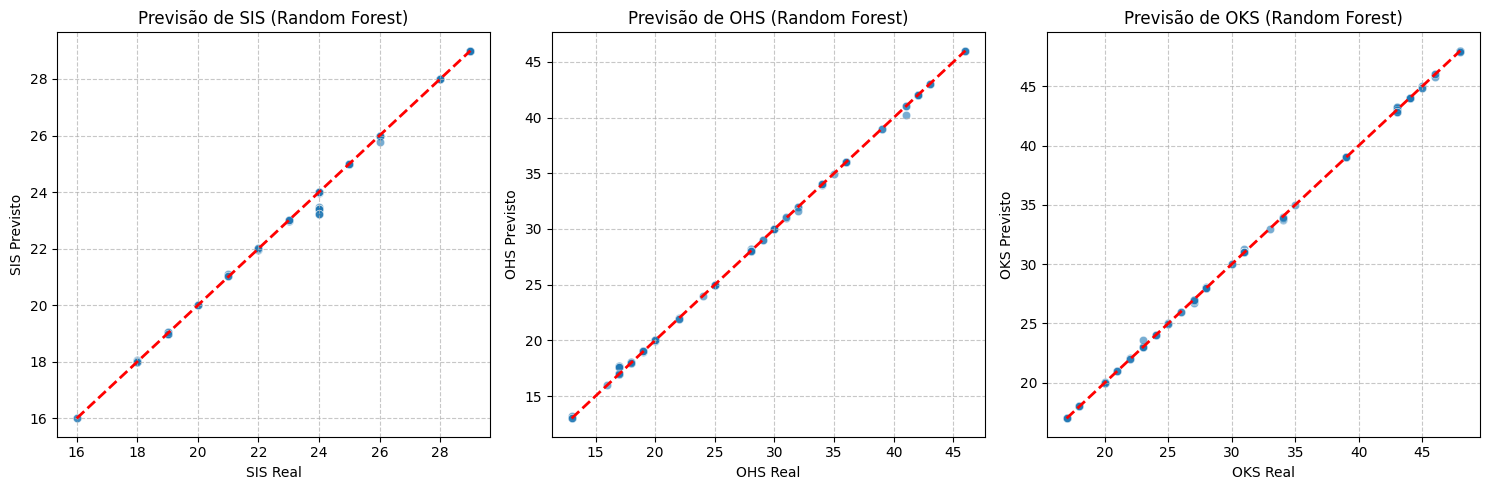

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor # Importante para prever múltiplos alvos
from sklearn.metrics import mean_squared_error, r2_score

# ##################################################################################################
# 1. CARREGAMENTO DOS DADOS
# ##################################################################################################
try:
    df_features = pd.read_csv('all-features-imputed.csv')
    df_demographic = pd.read_csv('demographic-coded.csv')
    print("Datasets carregados com sucesso.")
except FileNotFoundError:
    print("Erro: Certifique-se de que os arquivos CSV estão no diretório de execução do Colab.")
    exit()

# ##################################################################################################
# 2. PREPARAÇÃO DOS DADOS (Incluindo correções de nomes de colunas)
# ##################################################################################################

# CORREÇÃO: Renomear a coluna de ID para 'Participant_ID' para padronizar
# (Foi verificado que 'participant' é o nome correto nos arquivos)
df_features = df_features.rename(columns={'participant': 'Participant_ID'})
df_demographic = df_demographic.rename(columns={'participant': 'Participant_ID'})
df_demographic = df_demographic.rename(columns={'ID': 'Participant_ID'}, errors='ignore')

# Unir os dataframes pela chave correta
df_merged = pd.merge(df_features, df_demographic, on='Participant_ID', how='left')

# Variáveis-alvo
target_variables = ['sis', 'ohs', 'oks']

# Definir Features (X)
# REMOVEMOS: Variáveis-alvo, colunas de ID ('Participant_ID') e colunas de tempo ('timestamp', 'clinical-timestamp').
# Atenção: Se 'sis', 'ohs', e 'oks' são calculadas como soma/média de sub-escalas (ex: 'sis-01' a 'oks-12'),
# estas sub-escalas devem ser removidas das features para evitar *data leakage* e obter resultados realistas.
cols_to_drop = target_variables + ['Participant_ID', 'timestamp', 'clinical-timestamp']

# Para este script, assumimos que **apenas** as colunas de ID/Timestamp e as variáveis-alvo devem ser removidas.
features = df_merged.drop(columns=cols_to_drop, errors='ignore').columns.tolist()

# Separar X (features) e Y (targets)
X = df_merged[features]
Y = df_merged[target_variables]

# Separação Treino/Teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"\nNúmero de features utilizadas: {len(features)}")
print(f"Tamanho do conjunto de teste (X_test): {X_test.shape}")

# Identificar colunas numéricas e categóricas
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

# Criar o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# ##################################################################################################
# 3. MODELAGEM (Incluindo correção MultiOutputRegressor)
# ##################################################################################################

# CORREÇÃO: Usamos MultiOutputRegressor para envolver modelos que não suportam
# nativamente múltiplas variáveis-alvo (como LinearRegression e GradientBoosting).
models = {
    'Linear Regression': MultiOutputRegressor(LinearRegression()),
    'Random Forest Regressor': RandomForestRegressor(random_state=42, n_jobs=-1), # Suporta multi-output
    'Gradient Boosting Regressor': MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
}

results = {}

for name, model in models.items():
    print(f"\n--- Treinando e avaliando {name} ---")

    # Criar o pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])

    # Treinar o modelo
    pipeline.fit(X_train, Y_train)

    # Fazer previsões
    Y_pred = pipeline.predict(X_test)

    # Avaliar o modelo
    model_metrics = {}
    for i, target in enumerate(target_variables):
        mse = mean_squared_error(Y_test[target], Y_pred[:, i])
        rmse = np.sqrt(mse)
        r2 = r2_score(Y_test[target], Y_pred[:, i])
        model_metrics[target] = {'MSE': mse, 'RMSE': rmse, 'R2': r2}
        print(f"  {target}: MSE = {mse:.4f}, RMSE = {rmse:.4f}, R2 = {r2:.4f}")
    results[name] = model_metrics

# ##################################################################################################
# 4. SUMÁRIO E VISUALIZAÇÃO
# ##################################################################################################

print("\n" + "="*50)
print("### Sumário dos Resultados de Regressão ###")
print("="*50)
for model_name, metrics in results.items():
    print(f"\nModelo: {model_name}")
    for target, values in metrics.items():
        print(f"  {target}: MSE = {values['MSE']:.4f}, RMSE = {values['RMSE']:.4f}, R2 = {values['R2']:.4f}")

# Visualização das Previsões vs. Valores Reais (Random Forest)
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', RandomForestRegressor(random_state=42))])
rf_pipeline.fit(X_train, Y_train)
Y_pred_rf = rf_pipeline.predict(X_test)

targets_to_plot = ['sis', 'ohs', 'oks']
plt.figure(figsize=(15, 5))

for i, target in enumerate(targets_to_plot):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=Y_test[target], y=Y_pred_rf[:, i], alpha=0.6)

    # Adicionar a linha de identidade (y=x)
    min_val = min(Y_test[target].min(), Y_pred_rf[:, i].min())
    max_val = max(Y_test[target].max(), Y_pred_rf[:, i].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

    plt.xlabel(f"{target.upper()} Real")
    plt.ylabel(f"{target.upper()} Previsto")
    plt.title(f"Previsão de {target.upper()} (Random Forest)")
    plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()